In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
data = pd.read_csv('data/starbucks.csv')

In [3]:
data.head(3)

,Date,Close,Volume
0,2015-01-02,38.0061,6906098
1,2015-01-05,37.2781,11623796
2,2015-01-06,36.9748,7664340


Decompose a time series into component
- **trend-cycle**
- **seasonal**
- **remainder**

## 6.1 Time series components
- Additive decomposition : $y_t = S_t + T_t + R_t$
    - dose not vary with the level of the time series
- Multiplicative decomposition : $y_t = S_t * T_t * R_t$
    - if does, it is appropriate

## 6.2 Moving averages

### Moving average smoothing

$$\hat{T}_t = \frac{1}{m} \sum_{j=-k}^{k}{y_{t+j}}$$

- averaging values of the time series within $k$ periods of $t$
- eliminates randomness, leaving a smooth trend-cycle component
- call this an $m$-MA
- *some book has different approach* : only using past

In [34]:
data.rolling(window=5).mean().head(7) # different approach (using past)

,Close,Volume
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,37.72798,9819467.2
5,37.57398,13949588.8
6,37.60666,13629126.8


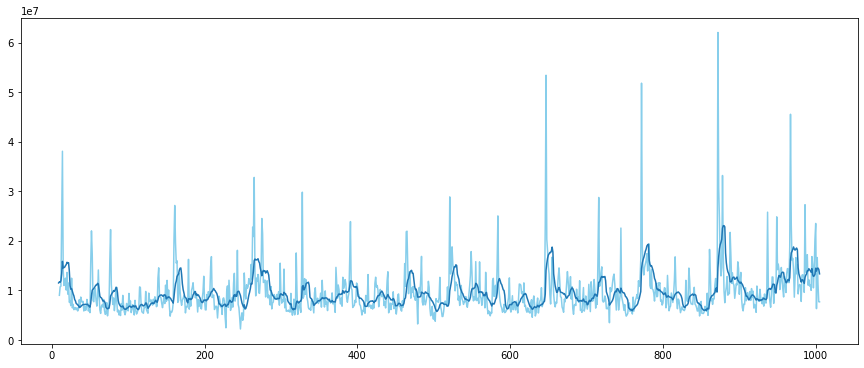

In [46]:
data['Volume'][10:].plot(figsize=(15,5), color='skyblue')
data.rolling(window=10).mean()['Volume'].plot(figsize=(15,6))

## 6.3 Classical decomposition
- Assume that the seasonal component is constant from year to year (maybe it can be a drawback)
- still widely used, but not recommended : there are now several much better methods
- bad
    - estimate of the trend-cycle is unavailable for the first, last observation (by MA)
    - trend-cycle estimate tends to over-smooth
    - assume that the seasonal component repeats from year to year
    - not robust to usual thing

### Additive decomposition
- step1 : Compute the trend-cycle component $\hat{T}_t$ using a m-MA
- step2 : Calculate the detrended series $y_t - \hat{T}_t$
- step3 : To estimate the seasonal component for each season, average the detrended values for that season $\hat{S}_t$
- step4 : Remainder component $\hat{R}_t = y_t - \hat{T}_t - \hat{S}_t$

Multiplicative decomposition is same but divide!

In [10]:
data['Date'] = pd.to_datetime(data['Date'])
data['month'] = data['Date'].dt.month

In [15]:
# step1
data['trend'] = data.rolling(window=5).mean()['Volume']
# step2
data['detrend'] = data['Volume'] - data['trend'] 

In [20]:
# step3
dic = data.groupby('month')['detrend'].mean().to_dict()
data['seasonal'] = data['month'].map(dic)

In [21]:
# step4
data['remainder'] = data['Volume'] - data['trend'] - data['seasonal']

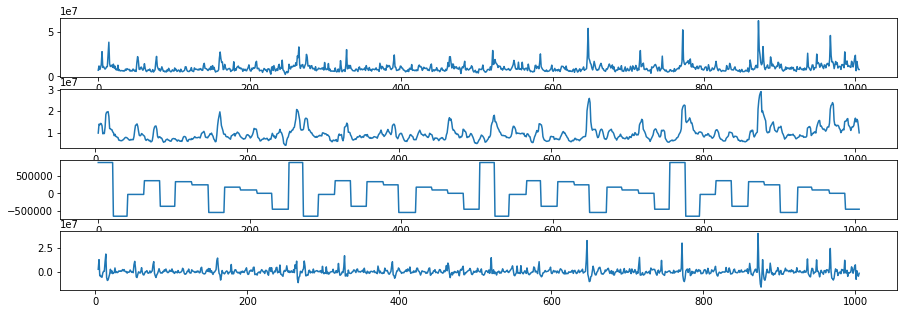

In [22]:
fig, axes = plt.subplots(4,1,figsize=(15,5))

axes[0].plot(data['Volume'])
axes[1].plot(data['trend'])
axes[2].plot(data['seasonal'])
axes[3].plot(data['remainder'])

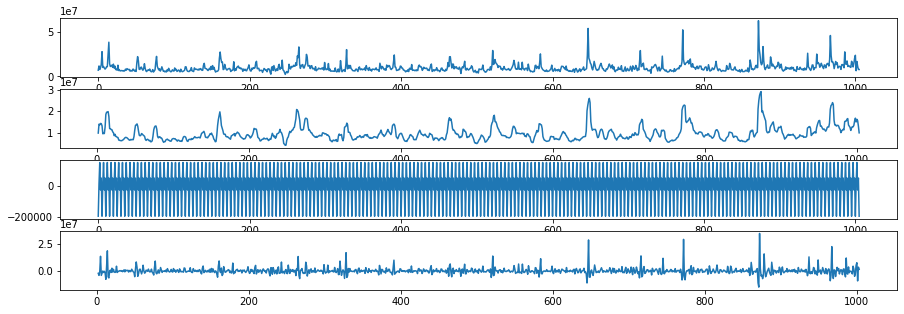

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose # moving average method
res = seasonal_decompose(data['Volume'], period=5)
trend = res.trend
seasonal = res.seasonal
residual = res.resid
observed = res.observed

fig, axes = plt.subplots(4,1,figsize=(15,5))

axes[0].plot(observed)
axes[1].plot(trend)
axes[2].plot(seasonal)
axes[3].plot(residual)
plt.show()

## 6.4 X11 decomposition
- based on classical decomposition but includes many extra step!
- available for all obs including end points
- handling trading day variation(holiday effect...)
- `seasonal` package in R
- details in 'Dagum & Bianconcini(2016)'

## 6.5 SEATS decomposition
- 'Seasonal Extraction in ARIMA'
- works only with quarterly and monthly data
- `seasonal` package in R
- details in 'Dagum & Bianconcini(2016)'

## 6.6 STL decomposition

- 'seasonal and Trend decomposition using Loess'
- advantage over the classival, SEATS, X11
    - unlike SEATS and X11, STL handle any type of seasonality
    - seasonal component is allowed to change over time, and the rate of change can be controlled by the user
    - smoothness of the trend-cycle and be controlled by the user
    - it can be robust to outliers. unusual observations will not affect the the estimates of the trend-cycle and seasonal components. but affect the remainder
- disadvantage
    - does not handle trading day or calender variation automatically
    - only provides for addtive decompositions

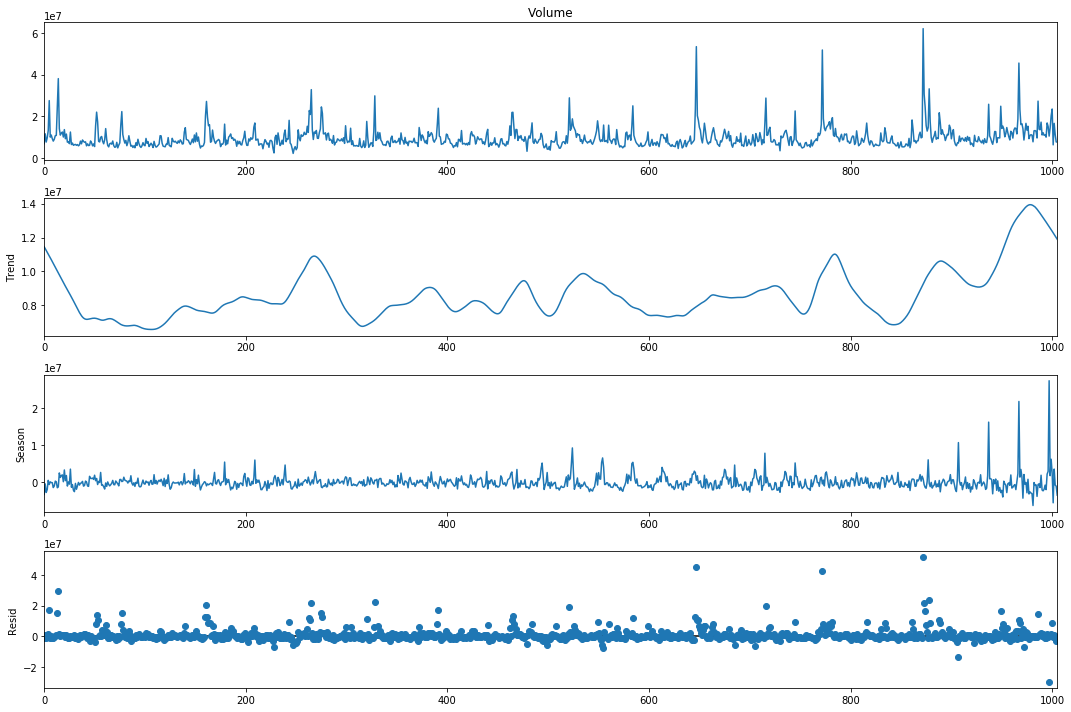

In [59]:
from statsmodels.tsa.seasonal import STL

res = STL(data['Volume'], period=30, seasonal=7 ,robust=True).fit()
plt.rc('figure',figsize=(15,10))
res.plot()
plt.show()

## 6.7 Measuring strength of trend and seasonality
- Time series decomposition can be used to measure the strength of trend and seasonality in a time series 

- Strength of trend
$$F_T = \max\left(0, 1 - \frac{\text{Var}(R_t)}{\text{Var}(T_t+R_t)}\right).$$
- Strength of seasonality
$$F_S = \max\left(0, 1 - \frac{\text{Var}(R_t)}{\text{Var}(S_{t}+R_t)}\right).$$